# Data & Env Initialization

In [1]:
import os, sys, gc

import zipfile
from os import path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

zip_file = "sample_data/Sky303.zip"
data_path = "sample_data/Sky303/"

if not path.exists(data_path):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall("sample_data/")

input_indice_path = data_path + "input_indices_{}.npy"
input_data_path = data_path + "input_data_{}.npy"
target_path = data_path + "output_indices_{}.npy"

# Constants

In [2]:
N_CONFIGURATIONS = 4262 # number of configuration of the problem
IMG_SHAPE = (1355, 3384, 3)
H, W = 128, 256 # the window size

CAMERA = np.array([[2304.5479, 0,  1686.2379], # the camera matrix
                          [0, 2305.8757, -0.0151],
                          [0, 0, 1.]], dtype=np.float32)

# Data Viz & Utils

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)
torch.__version__

'1.3.1+cu92'

In [4]:
class Sky303Dataset(Dataset):
    """Car dataset."""

    def __init__(self):
        super(Sky303Dataset,self).__init__()

    def __len__(self):
        return N_CONFIGURATIONS

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        indice_np = np.load(input_indice_path.format(idx))
        input_np = np.load(input_data_path.format(idx))
        target_np = np.load(target_path.format(idx))
        
        input_bin_mask = np.zeros([H, W, 1], dtype='float16')
        input_bin_mask[indice_np[:,0],indice_np[:,1],:] = 1.
        
        input_2Drepr = np.zeros([H, W, 3], dtype='float16')
        input_2Drepr[indice_np[:,0],indice_np[:,1],:] = input_np
        
        target_2Drepr = np.zeros([H, W, 1], dtype='float16')
        target_2Drepr[target_np[:,0],target_np[:,1],:] = 1.
        
        input_bin_mask = np.rollaxis(input_bin_mask, 2, 0)
        input_bin_mask = torch.from_numpy(input_bin_mask).float()
        
        input_2Drepr = np.rollaxis(input_2Drepr, 2, 0)
        input_2Drepr = torch.from_numpy(input_2Drepr).float()
        
        target_2Drepr = np.rollaxis(target_2Drepr, 2, 0)
        target_2Drepr = torch.from_numpy(target_2Drepr).float()
        
        return [input_bin_mask, input_2Drepr, target_2Drepr]

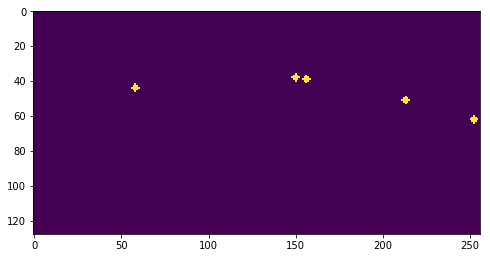

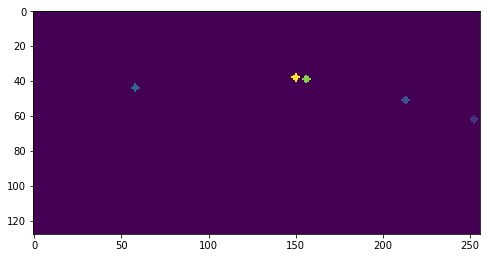

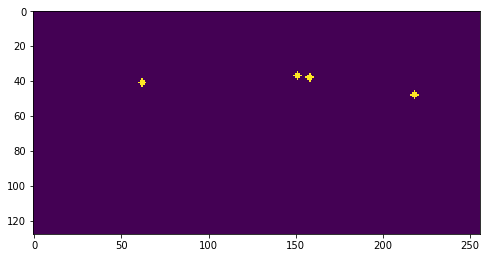

In [5]:
dataset = Sky303Dataset()
input_bin_mask, input_2Drepr, target_2Drepr = dataset[0]

plt.figure(figsize=(8,8))
plt.imshow((input_bin_mask.permute(1,2,0).numpy()[:,:,-1]).squeeze())
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(input_2Drepr.permute(1,2,0).numpy()[:,:,-1]/350.)
plt.show()

plt.figure(figsize=(8,8))
plt.imshow((target_2Drepr.permute(1,2,0).numpy()[:,:,-1]).squeeze())
plt.show()

# Model

In [6]:
import torch.nn as nn
import torch.optim as optim

# importing the importlib.util module
import importlib.util

# Define the module path
module_path = "../smap/smap.py"

# Load the module using importlib.util
spec = importlib.util.spec_from_file_location("smap", module_path)
smap_module = importlib.util.module_from_spec(spec)
sys.modules["smap"] = smap_module
spec.loader.exec_module(smap_module)

# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
class Model(nn.Module):
    def __init__(self, camera_matrix, n=0):
        super(Model,self).__init__()
        self.n = n
        self.camera_matrix = nn.Parameter(torch.from_numpy(camera_matrix), requires_grad=False)
        self.camera_matrix_inv = nn.Parameter(torch.from_numpy(np.linalg.inv(camera_matrix)), requires_grad=False)
        
        self.phi = nn.Parameter(torch.from_numpy(np.array([.0])).float().reshape(1,1), requires_grad=True)
        self.gamma = nn.Parameter(torch.from_numpy(np.array([.0])).float().reshape(1,1), requires_grad=True)
        self.rho = nn.Parameter(torch.from_numpy(np.array([.0])).float().reshape(1,1), requires_grad=True)
        self.theta = nn.Parameter(torch.from_numpy(np.array([0.,-0.,0.])).float().reshape(1,3,1,1), requires_grad=True)
        self.smap_layer = smap_module.SMap(n, IMG_SHAPE[0], IMG_SHAPE[1], camera_matrix, device)
        
        self.I00 = nn.Parameter(torch.from_numpy(np.array([[1.,.0,.0],[.0,0.,.0],[.0,.0,0.]])).float().reshape(3,3), requires_grad=False)
        self.I01 = nn.Parameter(torch.from_numpy(np.array([[0.,1.,.0],[.0,0.,.0],[.0,.0,0.]])).float().reshape(3,3), requires_grad=False)
        self.I10 = nn.Parameter(torch.from_numpy(np.array([[0.,.0,.0],[1.,0.,.0],[.0,.0,0.]])).float().reshape(3,3), requires_grad=False)
        self.I11 = nn.Parameter(torch.from_numpy(np.array([[0.,.0,.0],[.0,1.,.0],[.0,.0,0.]])).float().reshape(3,3), requires_grad=False)
        self.I22 = nn.Parameter(torch.from_numpy(np.array([[0.,.0,.0],[.0,0.,.0],[.0,.0,1.]])).float().reshape(3,3), requires_grad=False)
        
    def to_3d(self, z, height, width, panels, original_size):
        y_im, x_im = panels
        y_im, x_im = torch.from_numpy(y_im).reshape(height, width), torch.from_numpy(x_im).reshape(height, width)
        y_im = y_im * IMG_SHAPE[0] / original_size[0]
        x_im = x_im * IMG_SHAPE[1] / original_size[1]
        y_im, x_im = y_im.to(device), x_im.to(device)
        
        imp_co = torch.cat([torch.einsum('hw,bczhw->bczhw', x_im.float(), torch.ones_like(z.unsqueeze(2)).float()), torch.einsum('hw,bczhw->bczhw', y_im.float(), torch.ones_like(z.unsqueeze(2)).float()), torch.ones_like(z.unsqueeze(2))], 2)
        imp_co = imp_co.reshape(z.size(0),z.size(1),3,height,width)
        imp_co = torch.einsum('bchw,bczhw->bczhw', z.float(), imp_co.float()).reshape(z.size(0),z.size(1),3,-1)
        regr_co = torch.einsum('xz,yz->xy', imp_co.reshape(z.size(0),z.size(1),3,-1).permute(0,1,3,2).reshape(-1,3).float(), self.camera_matrix_inv.float())
        regr_co = regr_co.reshape(z.size(0),z.size(1),-1,3).permute(0,1,3,2).reshape(z.size(0),z.size(1),3,height*width)
        return regr_co
        
    def forward(self, r_x, r_mask, target_2Dr=None, zoom=0):
        mask = r_mask
        
        x = r_x[:,-1:,:,:]
        height, width = x.size(-2), x.size(-1)
        panels = list(np.where(np.ones([height, width])))
        panels[0] = panels[0] + .5
        panels[1] = panels[1] + .5
        
        x = self.to_3d(x[:,-1:,:,:].reshape(-1,1,height,width), height, width, panels, (height, width)).reshape(-1,3,height,width)
        
        phi = torch.tanh(3e-2*self.phi)*np.pi
        gamma = torch.tanh(3e-2*self.gamma)*np.pi
        rho = torch.tanh(3e-2*self.rho)*np.pi
        r = torch.cos(phi)*self.I00-torch.sin(phi)*self.I01+torch.sin(phi)*self.I10+torch.cos(phi)*self.I11+self.I22
        y = torch.cos(gamma)*self.I00-torch.sin(gamma)*self.I01+torch.sin(gamma)*self.I10+torch.cos(gamma)*self.I11+self.I22
        p = torch.cos(rho)*self.I00-torch.sin(rho)*self.I01+torch.sin(rho)*self.I10+torch.cos(rho)*self.I11+self.I22
        
        x_r = torch.einsum('bdef,cd->bcef',x,r.detach())+torch.einsum('bdef,cd->bcef',torch.sign(x),(r-r.detach()))
        x_r = torch.cat([x_r[:,1:,:,:],x_r[:,:1,:,:]],dim=1)
        x_r = torch.einsum('bdef,cd->bcef',x_r,y.detach())+torch.einsum('bdef,cd->bcef',torch.sign(x_r),(y-y.detach()))
        x_r = torch.cat([x_r[:,1:,:,:],x_r[:,:1,:,:]],dim=1)
        x_r = torch.einsum('bdef,cd->bcef',x_r,p.detach())+torch.einsum('bdef,cd->bcef',torch.sign(x_r),(p-p.detach()))
        x_r = torch.cat([x_r[:,1:,:,:],x_r[:,:1,:,:]],dim=1)
        
        x_t = x_r.detach()+self.theta
        x_t = torch.where((x[:,-1:,:,:])>0.,x_t,x_t.detach())
        x_t = torch.where((mask>.5),x_t,torch.zeros_like(x_t))
        k_t = torch.where((x_t[:,-1:,:,:])>0.,5./(torch.abs(x_t[:,-1:,:,:])+1e-7),torch.ones_like(x_t[:,-1:,:,:]))
        
        x_r = x_r+(mask>.5).float()*self.theta.detach()

        weights = self.smap_layer(torch.cat([k_t*x_t+(x_r-x_r.detach()), mask], dim=1), target_2Dr, zoom)

        return phi, gamma, rho, mask, weights

In [8]:
def create_model(camera_matrix, n):
    return Model(camera_matrix, n)

# Datasets

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, SequentialSampler, SubsetRandomSampler

In [10]:
train_idx, valid_idx= train_test_split(
    np.random.choice(np.arange(N_CONFIGURATIONS), size=512, replace=False), test_size=0.25, random_state=0, shuffle=True)

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SequentialSampler(valid_idx)

# Training

In [11]:
def l1_error(pred, target):
    shapes = target.size()
    m_batch_size, height, width = shapes[0], shapes[-2], shapes[-1]
    
    pred = pred.reshape(m_batch_size, -1, height*width)
    pred_m = (torch.max(pred.reshape(m_batch_size, -1, height*width),dim=1,keepdim=True).values>.5).float()
    target = target.reshape(m_batch_size, 1, -1)
    target_m = target.reshape(m_batch_size, 1, -1)
    
    loss = torch.abs(pred-target)
    loss_m = torch.abs(pred_m-target_m)*pred_m
    
    loss = loss.reshape(m_batch_size, -1).sum(dim=1)
    loss_m = loss_m.reshape(m_batch_size, -1).sum(dim=1)
    
    loss = torch.mean(loss_m).detach()+(loss-loss.detach()).sum()
    return loss

def train_loop_fn(loader, zoom, epoch, history=None):
    model.train()
    for batch_idx, (r_mask_batch, input_2Dr_batch, target_2Dr_batch) in enumerate(tqdm(loader)):
        m_batchsize, height, width = r_mask_batch.size(0), r_mask_batch.size(-2), r_mask_batch.size(-1)
        if m_batchsize != batch_size:
            break
        else:
            r_mask_batch, input_2Dr_batch, target_2Dr_batch = r_mask_batch.to(device), input_2Dr_batch.to(device), target_2Dr_batch.to(device)

        optimizer.zero_grad()
        
        r, p, y, r_mask, weights = model(input_2Dr_batch, r_mask_batch, target_2Dr_batch, zoom)
        
        target_2Dr = target_2Dr_batch.reshape(m_batchsize,1,H//(2**zoom),(2**zoom),W//(2**zoom),(2**zoom)).permute(0,3,5,1,2,4).reshape(m_batchsize,(2**(zoom+zoom)),1,H//(2**zoom),W//(2**zoom))
        target_2Dr, _ = torch.max(target_2Dr,dim=1,keepdim=False)
        
        r_mask = r_mask_batch.reshape(m_batchsize,1,H//(2**zoom),(2**zoom),W//(2**zoom),(2**zoom)).permute(0,3,5,1,2,4).reshape(m_batchsize,(2**(zoom+zoom)),1,H//(2**zoom),W//(2**zoom))
        r_mask, _ = torch.max(r_mask,dim=1,keepdim=False)


        loss = l1_error(weights, target_2Dr)
        
        loss.backward()
        optimizer.step()
        
        p = torch.tanh(3e-2*model.phi)*np.pi
        y = torch.tanh(3e-2*model.gamma)*np.pi
        r = torch.tanh(3e-2*model.rho)*np.pi
        print('theta_x: %.4f' % ((model.theta[0,0,0,0]).detach().cpu().numpy()))
        print('theta_y: %.4f' % ((model.theta[0,1,0,0]).detach().cpu().numpy()))
        print('theta_z: %.4f' % ((model.theta[0,2,0,0]).detach().cpu().numpy()))
        print('phi: %.4f' % ((r[0,0]).detach().cpu().numpy()))
        print('gamma: %.4f' % ((p[0,0]).detach().cpu().numpy()))
        print('rho: %.4f' % ((y[0,0]).detach().cpu().numpy()))

        loss_np = loss.detach().cpu().numpy()

        history.loc[(zoom, epoch, batch_idx), 'theta_x'] = (model.theta[0,0,0,0]).detach().cpu().numpy()
        history.loc[(zoom, epoch, batch_idx), 'theta_y'] = (model.theta[0,1,0,0]).detach().cpu().numpy()
        history.loc[(zoom, epoch, batch_idx), 'theta_z'] = (model.theta[0,2,0,0]).detach().cpu().numpy()
        history.loc[(zoom, epoch, batch_idx), 'phi'] = (r[0,0]).detach().cpu().numpy()
        history.loc[(zoom, epoch, batch_idx), 'gamma'] = (p[0,0]).detach().cpu().numpy()
        history.loc[(zoom, epoch, batch_idx), 'rho'] = (y[0,0]).detach().cpu().numpy()
        history.loc[(zoom, epoch, batch_idx), 'loss'] = loss_np
        
    print('Train Epoch: ({}, {}) \tLR: {:.6f}\tLoss: {:.6f}'.format(
            zoom, epoch,
            optimizer.state_dict()['param_groups'][0]['lr'],
            history['loss'].iloc[(-len(train_loader)+1):].mean()))
    
def evaluate_model(loader, key, history=None):
    model.eval()
    loss_np = 0.
    count = 0.

    with torch.no_grad():
        for batch_idx, (r_mask_batch, input_2Dr_batch, target_2Dr_batch) in enumerate(tqdm(loader)):
            m_batchsize = r_mask_batch.size(0)
            if m_batchsize != batch_size:
                break
            r_mask_batch, input_2Dr_batch, target_2Dr_batch = r_mask_batch.to(device), input_2Dr_batch.to(device), target_2Dr_batch.to(device)

            optimizer.zero_grad()

            r, p, y, r_mask, weights = model(input_2Dr_batch, r_mask_batch, target_2Dr_batch)
            
            l1 = l1_error(weights, target_2Dr_batch)
            loss_np += l1.detach().cpu().numpy()
            count = count+1.
    loss_np /= count
    history.loc[key, 'theta_x'] = (model.theta[0,0,0,0]).detach().cpu().numpy()
    history.loc[key, 'theta_y'] = (model.theta[0,1,0,0]).detach().cpu().numpy()
    history.loc[key, 'theta_z'] = (model.theta[0,2,0,0]).detach().cpu().numpy()
    history.loc[key, 'phi'] = (r[0,0]).detach().cpu().numpy()
    history.loc[key, 'gamma'] = (p[0,0]).detach().cpu().numpy()
    history.loc[key, 'rho'] = (y[0,0]).detach().cpu().numpy()
    history.loc[key, 'dev_loss'] = loss_np
    print("n_epochs: {} - lr: {}".format(*key))
    print('theta_x: {:.4f}'.format((model.theta[0,0,0,0]).detach().cpu().numpy()))
    print('theta_y: {:.4f}'.format((model.theta[0,1,0,0]).detach().cpu().numpy()))
    print('theta_z: {:.4f}'.format((model.theta[0,2,0,0]).detach().cpu().numpy()))
    print('phi: {:.4f}'.format((r[0,0]).detach().cpu().numpy()))
    print('gamma: {:.4f}'.format((p[0,0]).detach().cpu().numpy()))
    print('rho: {:.4f}'.format((y[0,0]).detach().cpu().numpy()))
    print('Dev loss: {:.4f}'.format(loss_np))

In [12]:
import time
%time


n_epochs_list = [2]
lr_list = [3e-4]
batch_size = 16
n = 4
optimizer = None
model = None


train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=0, sampler=train_sampler)
dev_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=0, sampler=valid_sampler)

fileName = None
dev_history = pd.DataFrame(index=pd.MultiIndex.from_tuples((), names=['epoch', 'lr']), columns=['theta_x', 'theta_y', 'theta_z', 'dev_loss'])

torch.cuda.empty_cache()
gc.collect()

for i_epoch in range(len(n_epochs_list)):
    for i_lr in range(len(lr_list)):
        n_epochs = n_epochs_list[i_epoch]
        lr = lr_list[i_lr]
        train_history = pd.DataFrame(index=pd.MultiIndex.from_tuples((), names=['zoom', 'epoch', 'batch_id']), columns=['theta_x', 'theta_y', 'theta_z', 'loss'])

        model = create_model(CAMERA, n)
        if fileName is not None:
            state_dict = torch.load(fileName, map_location='cpu')
            model.load_state_dict(state_dict, strict=False)
            del state_dict
            print("Loaded!!")
        model = model.to(device)

        torch.cuda.empty_cache()

        gc.collect()
        optimizer = optim.SGD(list(model.parameters()), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=n_epochs, gamma=.75)

        torch.cuda.empty_cache()
        gc.collect()

        for i in range(n+1):
            for epoch in range(n_epochs):
                zoom = n-i
                torch.cuda.empty_cache()
                gc.collect()

                loader = train_loader
                train_loop_fn(loader, zoom, epoch, train_history)
                
                scheduler.step()

        loader = dev_loader
        start = time.time()*1000.0
        evaluate_model(loader, (n_epochs, lr), dev_history)
        t_interval = time.time()*1000.0 - start
        print("Speed: {} ms/sample".format(t_interval/(len(dev_loader)*batch_size)))

        gc.collect()
        optimizer = None
        gc.collect()

        train_history.to_csv('train_history_{}_{}.csv'.format(i_epoch, i_lr))
        torch.save(model.state_dict(), "./model_{}_{}.pth".format(i_epoch, i_lr))
dev_history.to_csv('dev_history.csv')

Wall time: 0 ns


  4%|███▍                                                                               | 1/24 [00:00<00:19,  1.16it/s]

theta_x: 0.0134
theta_y: -0.0375
theta_z: 0.0127
phi: 0.0002
gamma: 0.0000
rho: 0.0007


  8%|██████▉                                                                            | 2/24 [00:01<00:18,  1.21it/s]

theta_x: 0.0184
theta_y: -0.0526
theta_z: 0.0188
phi: 0.0003
gamma: -0.0000
rho: 0.0011


 12%|██████████▍                                                                        | 3/24 [00:02<00:15,  1.32it/s]

theta_x: 0.0328
theta_y: -0.0678
theta_z: 0.0265
phi: 0.0006
gamma: -0.0002
rho: 0.0014


 17%|█████████████▊                                                                     | 4/24 [00:02<00:14,  1.41it/s]

theta_x: 0.0441
theta_y: -0.0800
theta_z: 0.0270
phi: 0.0007
gamma: -0.0005
rho: 0.0016


 21%|█████████████████▎                                                                 | 5/24 [00:03<00:13,  1.44it/s]

theta_x: 0.0490
theta_y: -0.0868
theta_z: 0.0312
phi: 0.0009
gamma: -0.0006
rho: 0.0018


 25%|████████████████████▊                                                              | 6/24 [00:04<00:13,  1.35it/s]

theta_x: 0.0558
theta_y: -0.1072
theta_z: 0.0376
phi: 0.0010
gamma: -0.0007
rho: 0.0023


 29%|████████████████████████▏                                                          | 7/24 [00:05<00:12,  1.33it/s]

theta_x: 0.0565
theta_y: -0.1228
theta_z: 0.0427
phi: 0.0011
gamma: -0.0009
rho: 0.0027


 33%|███████████████████████████▋                                                       | 8/24 [00:05<00:11,  1.41it/s]

theta_x: 0.0633
theta_y: -0.1335
theta_z: 0.0453
phi: 0.0012
gamma: -0.0011
rho: 0.0028


 38%|███████████████████████████████▏                                                   | 9/24 [00:06<00:10,  1.42it/s]

theta_x: 0.0639
theta_y: -0.1406
theta_z: 0.0481
phi: 0.0012
gamma: -0.0013
rho: 0.0030


 42%|██████████████████████████████████▏                                               | 10/24 [00:07<00:09,  1.45it/s]

theta_x: 0.0749
theta_y: -0.1547
theta_z: 0.0533
phi: 0.0015
gamma: -0.0016
rho: 0.0033


 46%|█████████████████████████████████████▌                                            | 11/24 [00:07<00:09,  1.41it/s]

theta_x: 0.0839
theta_y: -0.1688
theta_z: 0.0604
phi: 0.0016
gamma: -0.0019
rho: 0.0036


 50%|█████████████████████████████████████████                                         | 12/24 [00:08<00:08,  1.46it/s]

theta_x: 0.0877
theta_y: -0.1715
theta_z: 0.0594
phi: 0.0017
gamma: -0.0020
rho: 0.0037


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:09<00:07,  1.49it/s]

theta_x: 0.0971
theta_y: -0.1818
theta_z: 0.0591
phi: 0.0019
gamma: -0.0020
rho: 0.0039


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:09<00:06,  1.47it/s]

theta_x: 0.1103
theta_y: -0.1807
theta_z: 0.0627
phi: 0.0020
gamma: -0.0024
rho: 0.0039


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:10<00:06,  1.50it/s]

theta_x: 0.1141
theta_y: -0.1893
theta_z: 0.0675
phi: 0.0021
gamma: -0.0023
rho: 0.0041


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:11<00:05,  1.42it/s]

theta_x: 0.1268
theta_y: -0.1920
theta_z: 0.0634
phi: 0.0023
gamma: -0.0025
rho: 0.0041


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:11<00:04,  1.42it/s]

theta_x: 0.1309
theta_y: -0.1993
theta_z: 0.0641
phi: 0.0024
gamma: -0.0027
rho: 0.0042


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:12<00:04,  1.45it/s]

theta_x: 0.1372
theta_y: -0.2073
theta_z: 0.0691
phi: 0.0025
gamma: -0.0027
rho: 0.0044


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:13<00:03,  1.47it/s]

theta_x: 0.1382
theta_y: -0.2101
theta_z: 0.0696
phi: 0.0025
gamma: -0.0028
rho: 0.0045


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:13<00:02,  1.44it/s]

theta_x: 0.1418
theta_y: -0.2095
theta_z: 0.0674
phi: 0.0026
gamma: -0.0028
rho: 0.0045


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:14<00:02,  1.34it/s]

theta_x: 0.1537
theta_y: -0.2120
theta_z: 0.0699
phi: 0.0028
gamma: -0.0030
rho: 0.0045


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:15<00:01,  1.32it/s]

theta_x: 0.1587
theta_y: -0.2194
theta_z: 0.0725
phi: 0.0029
gamma: -0.0032
rho: 0.0046


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:16<00:00,  1.34it/s]

theta_x: 0.1594
theta_y: -0.2196
theta_z: 0.0724
phi: 0.0029
gamma: -0.0033
rho: 0.0046


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

theta_x: 0.1593
theta_y: -0.2192
theta_z: 0.0748
phi: 0.0028
gamma: -0.0031
rho: 0.0045
Train Epoch: (4, 0) 	LR: 0.000300	Loss: 1.211957


  4%|███▍                                                                               | 1/24 [00:00<00:08,  2.75it/s]

theta_x: 0.1638
theta_y: -0.2220
theta_z: 0.0764
phi: 0.0029
gamma: -0.0034
rho: 0.0046


  8%|██████▉                                                                            | 2/24 [00:00<00:07,  2.78it/s]

theta_x: 0.1677
theta_y: -0.2229
theta_z: 0.0777
phi: 0.0030
gamma: -0.0035
rho: 0.0046


 12%|██████████▍                                                                        | 3/24 [00:01<00:07,  2.80it/s]

theta_x: 0.1783
theta_y: -0.2283
theta_z: 0.0820
phi: 0.0031
gamma: -0.0035
rho: 0.0046


 17%|█████████████▊                                                                     | 4/24 [00:01<00:07,  2.83it/s]

theta_x: 0.1795
theta_y: -0.2294
theta_z: 0.0815
phi: 0.0032
gamma: -0.0036
rho: 0.0046


 21%|█████████████████▎                                                                 | 5/24 [00:01<00:06,  2.85it/s]

theta_x: 0.1863
theta_y: -0.2370
theta_z: 0.0866
phi: 0.0033
gamma: -0.0037
rho: 0.0047


 25%|████████████████████▊                                                              | 6/24 [00:02<00:06,  2.86it/s]

theta_x: 0.1941
theta_y: -0.2388
theta_z: 0.0905
phi: 0.0033
gamma: -0.0039
rho: 0.0047


 29%|████████████████████████▏                                                          | 7/24 [00:02<00:05,  2.87it/s]

theta_x: 0.2014
theta_y: -0.2396
theta_z: 0.0931
phi: 0.0034
gamma: -0.0040
rho: 0.0047


 33%|███████████████████████████▋                                                       | 8/24 [00:02<00:05,  2.87it/s]

theta_x: 0.2068
theta_y: -0.2409
theta_z: 0.0924
phi: 0.0036
gamma: -0.0041
rho: 0.0046


 38%|███████████████████████████████▏                                                   | 9/24 [00:03<00:05,  2.87it/s]

theta_x: 0.2086
theta_y: -0.2452
theta_z: 0.0941
phi: 0.0036
gamma: -0.0042
rho: 0.0047


 42%|██████████████████████████████████▏                                               | 10/24 [00:03<00:04,  2.84it/s]

theta_x: 0.2107
theta_y: -0.2503
theta_z: 0.0962
phi: 0.0036
gamma: -0.0043
rho: 0.0048


 46%|█████████████████████████████████████▌                                            | 11/24 [00:03<00:04,  2.87it/s]

theta_x: 0.2170
theta_y: -0.2486
theta_z: 0.0921
phi: 0.0037
gamma: -0.0044
rho: 0.0047


 50%|█████████████████████████████████████████                                         | 12/24 [00:04<00:04,  2.88it/s]

theta_x: 0.2169
theta_y: -0.2485
theta_z: 0.0921
phi: 0.0037
gamma: -0.0044
rho: 0.0047


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:04<00:03,  2.85it/s]

theta_x: 0.2215
theta_y: -0.2545
theta_z: 0.0933
phi: 0.0038
gamma: -0.0045
rho: 0.0048


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:04<00:03,  2.85it/s]

theta_x: 0.2205
theta_y: -0.2551
theta_z: 0.0940
phi: 0.0038
gamma: -0.0045
rho: 0.0048


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:05<00:03,  2.87it/s]

theta_x: 0.2239
theta_y: -0.2537
theta_z: 0.0933
phi: 0.0038
gamma: -0.0046
rho: 0.0048


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:05<00:02,  2.85it/s]

theta_x: 0.2255
theta_y: -0.2520
theta_z: 0.0920
phi: 0.0038
gamma: -0.0046
rho: 0.0047


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:05<00:02,  2.86it/s]

theta_x: 0.2275
theta_y: -0.2513
theta_z: 0.0902
phi: 0.0038
gamma: -0.0046
rho: 0.0047


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:06<00:02,  2.86it/s]

theta_x: 0.2317
theta_y: -0.2589
theta_z: 0.0938
phi: 0.0039
gamma: -0.0046
rho: 0.0048


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:06<00:01,  2.88it/s]

theta_x: 0.2318
theta_y: -0.2586
theta_z: 0.0936
phi: 0.0039
gamma: -0.0047
rho: 0.0047


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:06<00:01,  2.88it/s]

theta_x: 0.2315
theta_y: -0.2579
theta_z: 0.0936
phi: 0.0039
gamma: -0.0047
rho: 0.0046


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:07<00:01,  2.88it/s]

theta_x: 0.2353
theta_y: -0.2579
theta_z: 0.0923
phi: 0.0039
gamma: -0.0048
rho: 0.0046


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:07<00:00,  2.89it/s]

theta_x: 0.2353
theta_y: -0.2585
theta_z: 0.0925
phi: 0.0039
gamma: -0.0048
rho: 0.0046


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:08<00:00,  2.87it/s]

theta_x: 0.2355
theta_y: -0.2578
theta_z: 0.0923
phi: 0.0039
gamma: -0.0048
rho: 0.0045


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

theta_x: 0.2401
theta_y: -0.2573
theta_z: 0.0897
phi: 0.0040
gamma: -0.0050
rho: 0.0045
Train Epoch: (4, 1) 	LR: 0.000300	Loss: 0.915761


  4%|███▍                                                                               | 1/24 [00:00<00:17,  1.33it/s]

theta_x: 0.2464
theta_y: -0.2564
theta_z: 0.0884
phi: 0.0041
gamma: -0.0051
rho: 0.0044


  8%|██████▉                                                                            | 2/24 [00:01<00:16,  1.34it/s]

theta_x: 0.2499
theta_y: -0.2552
theta_z: 0.0868
phi: 0.0042
gamma: -0.0051
rho: 0.0044


 12%|██████████▍                                                                        | 3/24 [00:02<00:15,  1.35it/s]

theta_x: 0.2516
theta_y: -0.2543
theta_z: 0.0870
phi: 0.0042
gamma: -0.0051
rho: 0.0044


 17%|█████████████▊                                                                     | 4/24 [00:02<00:14,  1.36it/s]

theta_x: 0.2533
theta_y: -0.2545
theta_z: 0.0867
phi: 0.0042
gamma: -0.0050
rho: 0.0044


 21%|█████████████████▎                                                                 | 5/24 [00:03<00:13,  1.36it/s]

theta_x: 0.2562
theta_y: -0.2535
theta_z: 0.0856
phi: 0.0043
gamma: -0.0051
rho: 0.0043


 25%|████████████████████▊                                                              | 6/24 [00:04<00:13,  1.37it/s]

theta_x: 0.2576
theta_y: -0.2532
theta_z: 0.0851
phi: 0.0043
gamma: -0.0051
rho: 0.0043


 29%|████████████████████████▏                                                          | 7/24 [00:05<00:12,  1.37it/s]

theta_x: 0.2622
theta_y: -0.2526
theta_z: 0.0851
phi: 0.0044
gamma: -0.0051
rho: 0.0043


 33%|███████████████████████████▋                                                       | 8/24 [00:05<00:11,  1.37it/s]

theta_x: 0.2634
theta_y: -0.2529
theta_z: 0.0847
phi: 0.0044
gamma: -0.0051
rho: 0.0043


 38%|███████████████████████████████▏                                                   | 9/24 [00:06<00:10,  1.38it/s]

theta_x: 0.2639
theta_y: -0.2525
theta_z: 0.0845
phi: 0.0044
gamma: -0.0051
rho: 0.0043


 42%|██████████████████████████████████▏                                               | 10/24 [00:07<00:10,  1.38it/s]

theta_x: 0.2651
theta_y: -0.2519
theta_z: 0.0841
phi: 0.0044
gamma: -0.0051
rho: 0.0042


 46%|█████████████████████████████████████▌                                            | 11/24 [00:08<00:09,  1.38it/s]

theta_x: 0.2682
theta_y: -0.2517
theta_z: 0.0824
phi: 0.0045
gamma: -0.0052
rho: 0.0042


 50%|█████████████████████████████████████████                                         | 12/24 [00:08<00:08,  1.38it/s]

theta_x: 0.2738
theta_y: -0.2540
theta_z: 0.0833
phi: 0.0046
gamma: -0.0052
rho: 0.0043


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:09<00:07,  1.38it/s]

theta_x: 0.2752
theta_y: -0.2534
theta_z: 0.0833
phi: 0.0046
gamma: -0.0052
rho: 0.0042


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:10<00:07,  1.38it/s]

theta_x: 0.2801
theta_y: -0.2541
theta_z: 0.0821
phi: 0.0047
gamma: -0.0053
rho: 0.0043


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:10<00:06,  1.38it/s]

theta_x: 0.2863
theta_y: -0.2539
theta_z: 0.0801
phi: 0.0048
gamma: -0.0053
rho: 0.0043


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:11<00:05,  1.38it/s]

theta_x: 0.2863
theta_y: -0.2554
theta_z: 0.0805
phi: 0.0048
gamma: -0.0053
rho: 0.0043


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:12<00:05,  1.38it/s]

theta_x: 0.2868
theta_y: -0.2558
theta_z: 0.0802
phi: 0.0047
gamma: -0.0053
rho: 0.0043


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:13<00:04,  1.38it/s]

theta_x: 0.2879
theta_y: -0.2545
theta_z: 0.0797
phi: 0.0048
gamma: -0.0053
rho: 0.0043


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:13<00:03,  1.38it/s]

theta_x: 0.2921
theta_y: -0.2524
theta_z: 0.0800
phi: 0.0048
gamma: -0.0054
rho: 0.0042


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:14<00:02,  1.38it/s]

theta_x: 0.2927
theta_y: -0.2530
theta_z: 0.0801
phi: 0.0048
gamma: -0.0054
rho: 0.0042


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:15<00:02,  1.38it/s]

theta_x: 0.2953
theta_y: -0.2534
theta_z: 0.0793
phi: 0.0049
gamma: -0.0054
rho: 0.0042


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:15<00:01,  1.38it/s]

theta_x: 0.2969
theta_y: -0.2530
theta_z: 0.0783
phi: 0.0049
gamma: -0.0054
rho: 0.0042


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:16<00:00,  1.38it/s]

theta_x: 0.2974
theta_y: -0.2526
theta_z: 0.0783
phi: 0.0049
gamma: -0.0054
rho: 0.0041


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

theta_x: 0.2976
theta_y: -0.2519
theta_z: 0.0779
phi: 0.0049
gamma: -0.0054
rho: 0.0041
Train Epoch: (3, 0) 	LR: 0.000150	Loss: 1.793478


  4%|███▍                                                                               | 1/24 [00:00<00:17,  1.33it/s]

theta_x: 0.3040
theta_y: -0.2500
theta_z: 0.0737
phi: 0.0050
gamma: -0.0054
rho: 0.0041


  8%|██████▉                                                                            | 2/24 [00:01<00:16,  1.34it/s]

theta_x: 0.3057
theta_y: -0.2486
theta_z: 0.0727
phi: 0.0050
gamma: -0.0054
rho: 0.0040


 12%|██████████▍                                                                        | 3/24 [00:02<00:15,  1.35it/s]

theta_x: 0.3066
theta_y: -0.2482
theta_z: 0.0724
phi: 0.0050
gamma: -0.0054
rho: 0.0040


 17%|█████████████▊                                                                     | 4/24 [00:02<00:14,  1.36it/s]

theta_x: 0.3073
theta_y: -0.2480
theta_z: 0.0725
phi: 0.0051
gamma: -0.0054
rho: 0.0040


 21%|█████████████████▎                                                                 | 5/24 [00:03<00:13,  1.37it/s]

theta_x: 0.3079
theta_y: -0.2481
theta_z: 0.0723
phi: 0.0051
gamma: -0.0054
rho: 0.0040


 25%|████████████████████▊                                                              | 6/24 [00:04<00:13,  1.37it/s]

theta_x: 0.3087
theta_y: -0.2475
theta_z: 0.0721
phi: 0.0051
gamma: -0.0054
rho: 0.0039


 29%|████████████████████████▏                                                          | 7/24 [00:05<00:12,  1.36it/s]

theta_x: 0.3101
theta_y: -0.2478
theta_z: 0.0718
phi: 0.0051
gamma: -0.0054
rho: 0.0039


 33%|███████████████████████████▋                                                       | 8/24 [00:05<00:11,  1.37it/s]

theta_x: 0.3113
theta_y: -0.2472
theta_z: 0.0708
phi: 0.0051
gamma: -0.0054
rho: 0.0039


 38%|███████████████████████████████▏                                                   | 9/24 [00:06<00:10,  1.37it/s]

theta_x: 0.3121
theta_y: -0.2480
theta_z: 0.0712
phi: 0.0051
gamma: -0.0054
rho: 0.0039


 42%|██████████████████████████████████▏                                               | 10/24 [00:07<00:10,  1.37it/s]

theta_x: 0.3139
theta_y: -0.2480
theta_z: 0.0705
phi: 0.0052
gamma: -0.0054
rho: 0.0039


 46%|█████████████████████████████████████▌                                            | 11/24 [00:08<00:09,  1.37it/s]

theta_x: 0.3144
theta_y: -0.2479
theta_z: 0.0706
phi: 0.0052
gamma: -0.0054
rho: 0.0039


 50%|█████████████████████████████████████████                                         | 12/24 [00:08<00:08,  1.37it/s]

theta_x: 0.3173
theta_y: -0.2469
theta_z: 0.0715
phi: 0.0052
gamma: -0.0055
rho: 0.0039


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:09<00:08,  1.37it/s]

theta_x: 0.3186
theta_y: -0.2474
theta_z: 0.0712
phi: 0.0052
gamma: -0.0055
rho: 0.0039


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:10<00:07,  1.37it/s]

theta_x: 0.3185
theta_y: -0.2478
theta_z: 0.0712
phi: 0.0052
gamma: -0.0055
rho: 0.0039


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:10<00:06,  1.37it/s]

theta_x: 0.3188
theta_y: -0.2473
theta_z: 0.0710
phi: 0.0053
gamma: -0.0054
rho: 0.0039


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:11<00:05,  1.37it/s]

theta_x: 0.3189
theta_y: -0.2470
theta_z: 0.0710
phi: 0.0053
gamma: -0.0054
rho: 0.0039


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:12<00:05,  1.38it/s]

theta_x: 0.3193
theta_y: -0.2470
theta_z: 0.0710
phi: 0.0053
gamma: -0.0054
rho: 0.0038


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:13<00:04,  1.38it/s]

theta_x: 0.3253
theta_y: -0.2473
theta_z: 0.0695
phi: 0.0053
gamma: -0.0055
rho: 0.0038


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:13<00:03,  1.38it/s]

theta_x: 0.3252
theta_y: -0.2480
theta_z: 0.0698
phi: 0.0053
gamma: -0.0055
rho: 0.0038


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:14<00:02,  1.38it/s]

theta_x: 0.3248
theta_y: -0.2482
theta_z: 0.0700
phi: 0.0053
gamma: -0.0054
rho: 0.0038


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:15<00:02,  1.38it/s]

theta_x: 0.3251
theta_y: -0.2479
theta_z: 0.0699
phi: 0.0053
gamma: -0.0054
rho: 0.0038


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:16<00:01,  1.38it/s]

theta_x: 0.3257
theta_y: -0.2480
theta_z: 0.0696
phi: 0.0053
gamma: -0.0054
rho: 0.0038


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:16<00:00,  1.38it/s]

theta_x: 0.3266
theta_y: -0.2477
theta_z: 0.0695
phi: 0.0053
gamma: -0.0054
rho: 0.0038


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

theta_x: 0.3272
theta_y: -0.2474
theta_z: 0.0693
phi: 0.0053
gamma: -0.0054
rho: 0.0038
Train Epoch: (3, 1) 	LR: 0.000150	Loss: 1.440217


  4%|███▍                                                                               | 1/24 [00:01<00:27,  1.18s/it]

theta_x: 0.3295
theta_y: -0.2468
theta_z: 0.0685
phi: 0.0054
gamma: -0.0055
rho: 0.0037


  8%|██████▉                                                                            | 2/24 [00:02<00:25,  1.16s/it]

theta_x: 0.3311
theta_y: -0.2469
theta_z: 0.0686
phi: 0.0054
gamma: -0.0054
rho: 0.0037


 12%|██████████▍                                                                        | 3/24 [00:03<00:24,  1.16s/it]

theta_x: 0.3320
theta_y: -0.2462
theta_z: 0.0687
phi: 0.0054
gamma: -0.0054
rho: 0.0037


 17%|█████████████▊                                                                     | 4/24 [00:04<00:22,  1.15s/it]

theta_x: 0.3337
theta_y: -0.2463
theta_z: 0.0684
phi: 0.0055
gamma: -0.0055
rho: 0.0037


 21%|█████████████████▎                                                                 | 5/24 [00:05<00:21,  1.15s/it]

theta_x: 0.3337
theta_y: -0.2460
theta_z: 0.0684
phi: 0.0054
gamma: -0.0054
rho: 0.0037


 25%|████████████████████▊                                                              | 6/24 [00:06<00:20,  1.14s/it]

theta_x: 0.3360
theta_y: -0.2454
theta_z: 0.0672
phi: 0.0055
gamma: -0.0054
rho: 0.0036


 29%|████████████████████████▏                                                          | 7/24 [00:07<00:19,  1.14s/it]

theta_x: 0.3361
theta_y: -0.2450
theta_z: 0.0670
phi: 0.0055
gamma: -0.0054
rho: 0.0036


 33%|███████████████████████████▋                                                       | 8/24 [00:09<00:18,  1.14s/it]

theta_x: 0.3373
theta_y: -0.2450
theta_z: 0.0670
phi: 0.0055
gamma: -0.0054
rho: 0.0036


 38%|███████████████████████████████▏                                                   | 9/24 [00:10<00:17,  1.14s/it]

theta_x: 0.3396
theta_y: -0.2453
theta_z: 0.0661
phi: 0.0055
gamma: -0.0055
rho: 0.0036


 42%|██████████████████████████████████▏                                               | 10/24 [00:11<00:15,  1.14s/it]

theta_x: 0.3399
theta_y: -0.2449
theta_z: 0.0658
phi: 0.0055
gamma: -0.0055
rho: 0.0035


 46%|█████████████████████████████████████▌                                            | 11/24 [00:12<00:14,  1.14s/it]

theta_x: 0.3430
theta_y: -0.2446
theta_z: 0.0652
phi: 0.0055
gamma: -0.0055
rho: 0.0035


 50%|█████████████████████████████████████████                                         | 12/24 [00:13<00:13,  1.14s/it]

theta_x: 0.3447
theta_y: -0.2443
theta_z: 0.0662
phi: 0.0056
gamma: -0.0055
rho: 0.0035


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:14<00:12,  1.14s/it]

theta_x: 0.3455
theta_y: -0.2444
theta_z: 0.0662
phi: 0.0055
gamma: -0.0055
rho: 0.0035


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:15<00:11,  1.14s/it]

theta_x: 0.3466
theta_y: -0.2446
theta_z: 0.0664
phi: 0.0056
gamma: -0.0055
rho: 0.0034


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:17<00:10,  1.14s/it]

theta_x: 0.3468
theta_y: -0.2444
theta_z: 0.0663
phi: 0.0056
gamma: -0.0055
rho: 0.0034


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:18<00:09,  1.14s/it]

theta_x: 0.3481
theta_y: -0.2438
theta_z: 0.0660
phi: 0.0056
gamma: -0.0054
rho: 0.0034


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:19<00:07,  1.14s/it]

theta_x: 0.3486
theta_y: -0.2441
theta_z: 0.0655
phi: 0.0055
gamma: -0.0054
rho: 0.0034


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:20<00:06,  1.14s/it]

theta_x: 0.3489
theta_y: -0.2439
theta_z: 0.0650
phi: 0.0055
gamma: -0.0054
rho: 0.0033


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:21<00:05,  1.13s/it]

theta_x: 0.3497
theta_y: -0.2433
theta_z: 0.0645
phi: 0.0055
gamma: -0.0054
rho: 0.0033


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:22<00:04,  1.13s/it]

theta_x: 0.3503
theta_y: -0.2434
theta_z: 0.0647
phi: 0.0056
gamma: -0.0054
rho: 0.0033


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:23<00:03,  1.13s/it]

theta_x: 0.3502
theta_y: -0.2432
theta_z: 0.0645
phi: 0.0055
gamma: -0.0053
rho: 0.0033


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:25<00:02,  1.13s/it]

theta_x: 0.3517
theta_y: -0.2436
theta_z: 0.0646
phi: 0.0056
gamma: -0.0053
rho: 0.0032


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:26<00:01,  1.13s/it]

theta_x: 0.3523
theta_y: -0.2436
theta_z: 0.0643
phi: 0.0056
gamma: -0.0053
rho: 0.0032


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

theta_x: 0.3533
theta_y: -0.2433
theta_z: 0.0639
phi: 0.0056
gamma: -0.0053
rho: 0.0032
Train Epoch: (2, 0) 	LR: 0.000075	Loss: 4.263587


  4%|███▍                                                                               | 1/24 [00:01<00:27,  1.18s/it]

theta_x: 0.3533
theta_y: -0.2428
theta_z: 0.0638
phi: 0.0056
gamma: -0.0052
rho: 0.0032


  8%|██████▉                                                                            | 2/24 [00:02<00:25,  1.17s/it]

theta_x: 0.3545
theta_y: -0.2419
theta_z: 0.0636
phi: 0.0056
gamma: -0.0052
rho: 0.0031


 12%|██████████▍                                                                        | 3/24 [00:03<00:24,  1.16s/it]

theta_x: 0.3562
theta_y: -0.2422
theta_z: 0.0635
phi: 0.0056
gamma: -0.0052
rho: 0.0032


 17%|█████████████▊                                                                     | 4/24 [00:04<00:23,  1.15s/it]

theta_x: 0.3567
theta_y: -0.2417
theta_z: 0.0632
phi: 0.0056
gamma: -0.0052
rho: 0.0031


 21%|█████████████████▎                                                                 | 5/24 [00:05<00:21,  1.15s/it]

theta_x: 0.3581
theta_y: -0.2417
theta_z: 0.0630
phi: 0.0056
gamma: -0.0052
rho: 0.0031


 25%|████████████████████▊                                                              | 6/24 [00:06<00:20,  1.15s/it]

theta_x: 0.3585
theta_y: -0.2418
theta_z: 0.0627
phi: 0.0056
gamma: -0.0052
rho: 0.0031


 29%|████████████████████████▏                                                          | 7/24 [00:08<00:19,  1.14s/it]

theta_x: 0.3594
theta_y: -0.2417
theta_z: 0.0621
phi: 0.0056
gamma: -0.0052
rho: 0.0031


 33%|███████████████████████████▋                                                       | 8/24 [00:09<00:18,  1.14s/it]

theta_x: 0.3593
theta_y: -0.2416
theta_z: 0.0621
phi: 0.0056
gamma: -0.0051
rho: 0.0031


 38%|███████████████████████████████▏                                                   | 9/24 [00:10<00:17,  1.14s/it]

theta_x: 0.3604
theta_y: -0.2415
theta_z: 0.0618
phi: 0.0056
gamma: -0.0052
rho: 0.0031


 42%|██████████████████████████████████▏                                               | 10/24 [00:11<00:15,  1.14s/it]

theta_x: 0.3615
theta_y: -0.2417
theta_z: 0.0614
phi: 0.0056
gamma: -0.0051
rho: 0.0031


 46%|█████████████████████████████████████▌                                            | 11/24 [00:12<00:14,  1.14s/it]

theta_x: 0.3617
theta_y: -0.2414
theta_z: 0.0614
phi: 0.0056
gamma: -0.0051
rho: 0.0030


 50%|█████████████████████████████████████████                                         | 12/24 [00:13<00:13,  1.14s/it]

theta_x: 0.3627
theta_y: -0.2422
theta_z: 0.0617
phi: 0.0056
gamma: -0.0051
rho: 0.0030


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:14<00:12,  1.14s/it]

theta_x: 0.3625
theta_y: -0.2421
theta_z: 0.0615
phi: 0.0056
gamma: -0.0051
rho: 0.0030


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:15<00:11,  1.14s/it]

theta_x: 0.3628
theta_y: -0.2423
theta_z: 0.0614
phi: 0.0056
gamma: -0.0051
rho: 0.0030


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:17<00:10,  1.14s/it]

theta_x: 0.3640
theta_y: -0.2422
theta_z: 0.0608
phi: 0.0056
gamma: -0.0051
rho: 0.0030


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:18<00:09,  1.14s/it]

theta_x: 0.3646
theta_y: -0.2421
theta_z: 0.0609
phi: 0.0056
gamma: -0.0051
rho: 0.0030


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:19<00:07,  1.14s/it]

theta_x: 0.3658
theta_y: -0.2422
theta_z: 0.0603
phi: 0.0056
gamma: -0.0051
rho: 0.0030


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:20<00:06,  1.14s/it]

theta_x: 0.3660
theta_y: -0.2426
theta_z: 0.0603
phi: 0.0056
gamma: -0.0050
rho: 0.0030


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:21<00:05,  1.14s/it]

theta_x: 0.3661
theta_y: -0.2427
theta_z: 0.0603
phi: 0.0056
gamma: -0.0050
rho: 0.0030


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:22<00:04,  1.14s/it]

theta_x: 0.3664
theta_y: -0.2427
theta_z: 0.0605
phi: 0.0056
gamma: -0.0050
rho: 0.0029


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:23<00:03,  1.14s/it]

theta_x: 0.3675
theta_y: -0.2429
theta_z: 0.0599
phi: 0.0056
gamma: -0.0050
rho: 0.0029


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:25<00:02,  1.14s/it]

theta_x: 0.3676
theta_y: -0.2429
theta_z: 0.0598
phi: 0.0056
gamma: -0.0050
rho: 0.0029


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:26<00:01,  1.14s/it]

theta_x: 0.3684
theta_y: -0.2430
theta_z: 0.0597
phi: 0.0056
gamma: -0.0050
rho: 0.0029


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

theta_x: 0.3687
theta_y: -0.2430
theta_z: 0.0595
phi: 0.0056
gamma: -0.0050
rho: 0.0029
Train Epoch: (2, 1) 	LR: 0.000075	Loss: 3.923913


  4%|███▍                                                                               | 1/24 [00:01<00:36,  1.60s/it]

theta_x: 0.3693
theta_y: -0.2431
theta_z: 0.0599
phi: 0.0056
gamma: -0.0049
rho: 0.0029


  8%|██████▉                                                                            | 2/24 [00:03<00:34,  1.59s/it]

theta_x: 0.3707
theta_y: -0.2430
theta_z: 0.0598
phi: 0.0055
gamma: -0.0049
rho: 0.0028


 12%|██████████▍                                                                        | 3/24 [00:04<00:33,  1.58s/it]

theta_x: 0.3703
theta_y: -0.2431
theta_z: 0.0598
phi: 0.0055
gamma: -0.0048
rho: 0.0028


 17%|█████████████▊                                                                     | 4/24 [00:06<00:31,  1.57s/it]

theta_x: 0.3708
theta_y: -0.2427
theta_z: 0.0593
phi: 0.0055
gamma: -0.0047
rho: 0.0028


 21%|█████████████████▎                                                                 | 5/24 [00:07<00:29,  1.57s/it]

theta_x: 0.3707
theta_y: -0.2418
theta_z: 0.0590
phi: 0.0054
gamma: -0.0046
rho: 0.0027


 25%|████████████████████▊                                                              | 6/24 [00:09<00:28,  1.57s/it]

theta_x: 0.3723
theta_y: -0.2427
theta_z: 0.0591
phi: 0.0054
gamma: -0.0046
rho: 0.0027


 29%|████████████████████████▏                                                          | 7/24 [00:10<00:26,  1.56s/it]

theta_x: 0.3727
theta_y: -0.2430
theta_z: 0.0594
phi: 0.0053
gamma: -0.0045
rho: 0.0027


 33%|███████████████████████████▋                                                       | 8/24 [00:12<00:25,  1.56s/it]

theta_x: 0.3734
theta_y: -0.2430
theta_z: 0.0595
phi: 0.0053
gamma: -0.0045
rho: 0.0027


 38%|███████████████████████████████▏                                                   | 9/24 [00:14<00:23,  1.56s/it]

theta_x: 0.3742
theta_y: -0.2432
theta_z: 0.0592
phi: 0.0053
gamma: -0.0044
rho: 0.0027


 42%|██████████████████████████████████▏                                               | 10/24 [00:15<00:21,  1.56s/it]

theta_x: 0.3749
theta_y: -0.2433
theta_z: 0.0593
phi: 0.0053
gamma: -0.0043
rho: 0.0026


 46%|█████████████████████████████████████▌                                            | 11/24 [00:17<00:20,  1.56s/it]

theta_x: 0.3745
theta_y: -0.2429
theta_z: 0.0590
phi: 0.0052
gamma: -0.0043
rho: 0.0026


 50%|█████████████████████████████████████████                                         | 12/24 [00:18<00:18,  1.56s/it]

theta_x: 0.3756
theta_y: -0.2430
theta_z: 0.0586
phi: 0.0052
gamma: -0.0042
rho: 0.0026


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:20<00:17,  1.55s/it]

theta_x: 0.3762
theta_y: -0.2424
theta_z: 0.0578
phi: 0.0052
gamma: -0.0042
rho: 0.0026


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:21<00:15,  1.55s/it]

theta_x: 0.3769
theta_y: -0.2430
theta_z: 0.0575
phi: 0.0052
gamma: -0.0041
rho: 0.0026


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:23<00:13,  1.55s/it]

theta_x: 0.3788
theta_y: -0.2430
theta_z: 0.0568
phi: 0.0052
gamma: -0.0041
rho: 0.0025


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:24<00:12,  1.55s/it]

theta_x: 0.3792
theta_y: -0.2426
theta_z: 0.0563
phi: 0.0052
gamma: -0.0041
rho: 0.0025


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:26<00:10,  1.56s/it]

theta_x: 0.3789
theta_y: -0.2428
theta_z: 0.0562
phi: 0.0051
gamma: -0.0040
rho: 0.0025


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:28<00:09,  1.56s/it]

theta_x: 0.3791
theta_y: -0.2428
theta_z: 0.0560
phi: 0.0051
gamma: -0.0040
rho: 0.0025


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:29<00:07,  1.55s/it]

theta_x: 0.3798
theta_y: -0.2430
theta_z: 0.0560
phi: 0.0051
gamma: -0.0039
rho: 0.0025


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:31<00:06,  1.56s/it]

theta_x: 0.3804
theta_y: -0.2432
theta_z: 0.0559
phi: 0.0051
gamma: -0.0039
rho: 0.0025


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:32<00:04,  1.56s/it]

theta_x: 0.3818
theta_y: -0.2439
theta_z: 0.0564
phi: 0.0050
gamma: -0.0039
rho: 0.0024


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:34<00:03,  1.56s/it]

theta_x: 0.3821
theta_y: -0.2440
theta_z: 0.0561
phi: 0.0050
gamma: -0.0038
rho: 0.0024


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:35<00:01,  1.56s/it]

theta_x: 0.3828
theta_y: -0.2437
theta_z: 0.0553
phi: 0.0050
gamma: -0.0037
rho: 0.0024


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

theta_x: 0.3838
theta_y: -0.2437
theta_z: 0.0556
phi: 0.0050
gamma: -0.0037
rho: 0.0024
Train Epoch: (1, 0) 	LR: 0.000037	Loss: 12.184783


  4%|███▍                                                                               | 1/24 [00:01<00:36,  1.61s/it]

theta_x: 0.3846
theta_y: -0.2434
theta_z: 0.0553
phi: 0.0050
gamma: -0.0037
rho: 0.0023


  8%|██████▉                                                                            | 2/24 [00:03<00:35,  1.59s/it]

theta_x: 0.3849
theta_y: -0.2438
theta_z: 0.0549
phi: 0.0049
gamma: -0.0036
rho: 0.0023


 12%|██████████▍                                                                        | 3/24 [00:04<00:33,  1.58s/it]

theta_x: 0.3847
theta_y: -0.2439
theta_z: 0.0549
phi: 0.0049
gamma: -0.0036
rho: 0.0023


 17%|█████████████▊                                                                     | 4/24 [00:06<00:31,  1.58s/it]

theta_x: 0.3856
theta_y: -0.2447
theta_z: 0.0547
phi: 0.0049
gamma: -0.0036
rho: 0.0023


 21%|█████████████████▎                                                                 | 5/24 [00:07<00:29,  1.58s/it]

theta_x: 0.3858
theta_y: -0.2451
theta_z: 0.0547
phi: 0.0049
gamma: -0.0035
rho: 0.0023


 25%|████████████████████▊                                                              | 6/24 [00:09<00:28,  1.57s/it]

theta_x: 0.3860
theta_y: -0.2456
theta_z: 0.0546
phi: 0.0048
gamma: -0.0035
rho: 0.0023


 29%|████████████████████████▏                                                          | 7/24 [00:10<00:26,  1.57s/it]

theta_x: 0.3868
theta_y: -0.2454
theta_z: 0.0544
phi: 0.0048
gamma: -0.0034
rho: 0.0023


 33%|███████████████████████████▋                                                       | 8/24 [00:12<00:25,  1.57s/it]

theta_x: 0.3871
theta_y: -0.2453
theta_z: 0.0543
phi: 0.0048
gamma: -0.0034
rho: 0.0023


 38%|███████████████████████████████▏                                                   | 9/24 [00:14<00:23,  1.57s/it]

theta_x: 0.3879
theta_y: -0.2450
theta_z: 0.0538
phi: 0.0048
gamma: -0.0033
rho: 0.0023


 42%|██████████████████████████████████▏                                               | 10/24 [00:15<00:21,  1.57s/it]

theta_x: 0.3879
theta_y: -0.2452
theta_z: 0.0536
phi: 0.0048
gamma: -0.0033
rho: 0.0022


 46%|█████████████████████████████████████▌                                            | 11/24 [00:17<00:20,  1.57s/it]

theta_x: 0.3896
theta_y: -0.2456
theta_z: 0.0534
phi: 0.0048
gamma: -0.0033
rho: 0.0023


 50%|█████████████████████████████████████████                                         | 12/24 [00:18<00:18,  1.57s/it]

theta_x: 0.3898
theta_y: -0.2459
theta_z: 0.0534
phi: 0.0047
gamma: -0.0033
rho: 0.0022


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:20<00:17,  1.57s/it]

theta_x: 0.3900
theta_y: -0.2458
theta_z: 0.0531
phi: 0.0047
gamma: -0.0032
rho: 0.0022


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:21<00:15,  1.56s/it]

theta_x: 0.3912
theta_y: -0.2466
theta_z: 0.0539
phi: 0.0047
gamma: -0.0032
rho: 0.0022


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:23<00:14,  1.56s/it]

theta_x: 0.3929
theta_y: -0.2476
theta_z: 0.0545
phi: 0.0047
gamma: -0.0032
rho: 0.0022


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:25<00:12,  1.56s/it]

theta_x: 0.3934
theta_y: -0.2480
theta_z: 0.0544
phi: 0.0047
gamma: -0.0031
rho: 0.0022


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:26<00:10,  1.56s/it]

theta_x: 0.3946
theta_y: -0.2483
theta_z: 0.0541
phi: 0.0047
gamma: -0.0031
rho: 0.0022


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:28<00:09,  1.56s/it]

theta_x: 0.3952
theta_y: -0.2481
theta_z: 0.0537
phi: 0.0047
gamma: -0.0031
rho: 0.0022


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:29<00:07,  1.56s/it]

theta_x: 0.3951
theta_y: -0.2478
theta_z: 0.0533
phi: 0.0046
gamma: -0.0030
rho: 0.0022


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:31<00:06,  1.56s/it]

theta_x: 0.3967
theta_y: -0.2483
theta_z: 0.0533
phi: 0.0046
gamma: -0.0030
rho: 0.0022


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:32<00:04,  1.56s/it]

theta_x: 0.3969
theta_y: -0.2481
theta_z: 0.0531
phi: 0.0046
gamma: -0.0030
rho: 0.0021


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:34<00:03,  1.56s/it]

theta_x: 0.3967
theta_y: -0.2481
theta_z: 0.0531
phi: 0.0045
gamma: -0.0029
rho: 0.0021


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:35<00:01,  1.56s/it]

theta_x: 0.3970
theta_y: -0.2477
theta_z: 0.0528
phi: 0.0045
gamma: -0.0029
rho: 0.0021


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

theta_x: 0.3969
theta_y: -0.2479
theta_z: 0.0529
phi: 0.0045
gamma: -0.0028
rho: 0.0021
Train Epoch: (1, 1) 	LR: 0.000037	Loss: 10.932065


  4%|███▍                                                                               | 1/24 [00:02<00:47,  2.06s/it]

theta_x: 0.3968
theta_y: -0.2477
theta_z: 0.0526
phi: 0.0044
gamma: -0.0027
rho: 0.0021


  8%|██████▉                                                                            | 2/24 [00:04<00:44,  2.04s/it]

theta_x: 0.3965
theta_y: -0.2472
theta_z: 0.0523
phi: 0.0043
gamma: -0.0026
rho: 0.0020


 12%|██████████▍                                                                        | 3/24 [00:06<00:42,  2.03s/it]

theta_x: 0.3962
theta_y: -0.2469
theta_z: 0.0521
phi: 0.0043
gamma: -0.0025
rho: 0.0020


 17%|█████████████▊                                                                     | 4/24 [00:08<00:40,  2.01s/it]

theta_x: 0.3969
theta_y: -0.2470
theta_z: 0.0517
phi: 0.0042
gamma: -0.0025
rho: 0.0019


 21%|█████████████████▎                                                                 | 5/24 [00:10<00:38,  2.01s/it]

theta_x: 0.3967
theta_y: -0.2470
theta_z: 0.0514
phi: 0.0042
gamma: -0.0024
rho: 0.0019


 25%|████████████████████▊                                                              | 6/24 [00:12<00:35,  2.00s/it]

theta_x: 0.3968
theta_y: -0.2470
theta_z: 0.0513
phi: 0.0041
gamma: -0.0024
rho: 0.0019


 29%|████████████████████████▏                                                          | 7/24 [00:13<00:33,  2.00s/it]

theta_x: 0.3968
theta_y: -0.2468
theta_z: 0.0510
phi: 0.0041
gamma: -0.0023
rho: 0.0019


 33%|███████████████████████████▋                                                       | 8/24 [00:15<00:31,  1.99s/it]

theta_x: 0.3977
theta_y: -0.2475
theta_z: 0.0509
phi: 0.0041
gamma: -0.0023
rho: 0.0019


 38%|███████████████████████████████▏                                                   | 9/24 [00:17<00:29,  1.99s/it]

theta_x: 0.3983
theta_y: -0.2478
theta_z: 0.0509
phi: 0.0040
gamma: -0.0022
rho: 0.0018


 42%|██████████████████████████████████▏                                               | 10/24 [00:19<00:27,  1.99s/it]

theta_x: 0.3983
theta_y: -0.2478
theta_z: 0.0507
phi: 0.0040
gamma: -0.0021
rho: 0.0018


 46%|█████████████████████████████████████▌                                            | 11/24 [00:21<00:25,  1.99s/it]

theta_x: 0.3985
theta_y: -0.2482
theta_z: 0.0508
phi: 0.0039
gamma: -0.0021
rho: 0.0018


 50%|█████████████████████████████████████████                                         | 12/24 [00:23<00:23,  1.99s/it]

theta_x: 0.3992
theta_y: -0.2484
theta_z: 0.0508
phi: 0.0039
gamma: -0.0020
rho: 0.0018


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:25<00:21,  1.99s/it]

theta_x: 0.4002
theta_y: -0.2489
theta_z: 0.0508
phi: 0.0039
gamma: -0.0020
rho: 0.0018


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:27<00:19,  1.99s/it]

theta_x: 0.4007
theta_y: -0.2494
theta_z: 0.0509
phi: 0.0038
gamma: -0.0019
rho: 0.0018


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:29<00:17,  1.99s/it]

theta_x: 0.4012
theta_y: -0.2494
theta_z: 0.0507
phi: 0.0038
gamma: -0.0019
rho: 0.0017


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:31<00:15,  1.99s/it]

theta_x: 0.4013
theta_y: -0.2495
theta_z: 0.0507
phi: 0.0038
gamma: -0.0018
rho: 0.0017


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:33<00:13,  1.99s/it]

theta_x: 0.4016
theta_y: -0.2498
theta_z: 0.0507
phi: 0.0037
gamma: -0.0018
rho: 0.0017


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:35<00:12,  2.00s/it]

theta_x: 0.4018
theta_y: -0.2496
theta_z: 0.0506
phi: 0.0037
gamma: -0.0017
rho: 0.0017


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:37<00:09,  2.00s/it]

theta_x: 0.4023
theta_y: -0.2499
theta_z: 0.0504
phi: 0.0037
gamma: -0.0017
rho: 0.0017


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:39<00:07,  1.99s/it]

theta_x: 0.4026
theta_y: -0.2498
theta_z: 0.0502
phi: 0.0036
gamma: -0.0016
rho: 0.0016


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:41<00:05,  2.00s/it]

theta_x: 0.4030
theta_y: -0.2501
theta_z: 0.0502
phi: 0.0036
gamma: -0.0016
rho: 0.0016


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:43<00:03,  1.99s/it]

theta_x: 0.4034
theta_y: -0.2502
theta_z: 0.0498
phi: 0.0035
gamma: -0.0015
rho: 0.0016


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:45<00:01,  1.99s/it]

theta_x: 0.4043
theta_y: -0.2508
theta_z: 0.0498
phi: 0.0035
gamma: -0.0015
rho: 0.0016


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

theta_x: 0.4049
theta_y: -0.2509
theta_z: 0.0494
phi: 0.0035
gamma: -0.0015
rho: 0.0016
Train Epoch: (0, 0) 	LR: 0.000019	Loss: 29.220109


  4%|███▍                                                                               | 1/24 [00:02<00:47,  2.05s/it]

theta_x: 0.4053
theta_y: -0.2514
theta_z: 0.0493
phi: 0.0035
gamma: -0.0014
rho: 0.0016


  8%|██████▉                                                                            | 2/24 [00:04<00:44,  2.03s/it]

theta_x: 0.4061
theta_y: -0.2516
theta_z: 0.0489
phi: 0.0035
gamma: -0.0014
rho: 0.0015


 12%|██████████▍                                                                        | 3/24 [00:06<00:42,  2.02s/it]

theta_x: 0.4068
theta_y: -0.2517
theta_z: 0.0485
phi: 0.0034
gamma: -0.0014
rho: 0.0015


 17%|█████████████▊                                                                     | 4/24 [00:08<00:40,  2.01s/it]

theta_x: 0.4072
theta_y: -0.2519
theta_z: 0.0483
phi: 0.0034
gamma: -0.0014
rho: 0.0015


 21%|█████████████████▎                                                                 | 5/24 [00:10<00:38,  2.01s/it]

theta_x: 0.4080
theta_y: -0.2520
theta_z: 0.0481
phi: 0.0034
gamma: -0.0013
rho: 0.0015


 25%|████████████████████▊                                                              | 6/24 [00:12<00:36,  2.00s/it]

theta_x: 0.4090
theta_y: -0.2524
theta_z: 0.0483
phi: 0.0034
gamma: -0.0013
rho: 0.0015


 29%|████████████████████████▏                                                          | 7/24 [00:14<00:34,  2.00s/it]

theta_x: 0.4094
theta_y: -0.2526
theta_z: 0.0481
phi: 0.0033
gamma: -0.0013
rho: 0.0015


 33%|███████████████████████████▋                                                       | 8/24 [00:16<00:32,  2.00s/it]

theta_x: 0.4104
theta_y: -0.2531
theta_z: 0.0482
phi: 0.0033
gamma: -0.0013
rho: 0.0015


 38%|███████████████████████████████▏                                                   | 9/24 [00:18<00:29,  2.00s/it]

theta_x: 0.4106
theta_y: -0.2531
theta_z: 0.0481
phi: 0.0033
gamma: -0.0012
rho: 0.0014


 42%|██████████████████████████████████▏                                               | 10/24 [00:20<00:27,  2.00s/it]

theta_x: 0.4111
theta_y: -0.2532
theta_z: 0.0480
phi: 0.0033
gamma: -0.0012
rho: 0.0014


 46%|█████████████████████████████████████▌                                            | 11/24 [00:21<00:25,  2.00s/it]

theta_x: 0.4112
theta_y: -0.2531
theta_z: 0.0478
phi: 0.0033
gamma: -0.0012
rho: 0.0014


 50%|█████████████████████████████████████████                                         | 12/24 [00:24<00:24,  2.01s/it]

theta_x: 0.4124
theta_y: -0.2536
theta_z: 0.0477
phi: 0.0032
gamma: -0.0012
rho: 0.0014


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:26<00:22,  2.02s/it]

theta_x: 0.4129
theta_y: -0.2540
theta_z: 0.0476
phi: 0.0032
gamma: -0.0012
rho: 0.0014


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:28<00:20,  2.04s/it]

theta_x: 0.4132
theta_y: -0.2545
theta_z: 0.0476
phi: 0.0032
gamma: -0.0011
rho: 0.0014


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:30<00:18,  2.03s/it]

theta_x: 0.4132
theta_y: -0.2545
theta_z: 0.0477
phi: 0.0032
gamma: -0.0011
rho: 0.0013


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:32<00:16,  2.01s/it]

theta_x: 0.4140
theta_y: -0.2551
theta_z: 0.0475
phi: 0.0032
gamma: -0.0011
rho: 0.0013


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:34<00:14,  2.01s/it]

theta_x: 0.4144
theta_y: -0.2553
theta_z: 0.0474
phi: 0.0032
gamma: -0.0010
rho: 0.0013


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:36<00:12,  2.01s/it]

theta_x: 0.4149
theta_y: -0.2555
theta_z: 0.0476
phi: 0.0031
gamma: -0.0010
rho: 0.0013


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:38<00:10,  2.01s/it]

theta_x: 0.4156
theta_y: -0.2558
theta_z: 0.0475
phi: 0.0031
gamma: -0.0010
rho: 0.0013


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:40<00:08,  2.01s/it]

theta_x: 0.4164
theta_y: -0.2562
theta_z: 0.0474
phi: 0.0031
gamma: -0.0010
rho: 0.0013


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:42<00:06,  2.01s/it]

theta_x: 0.4170
theta_y: -0.2566
theta_z: 0.0476
phi: 0.0031
gamma: -0.0010
rho: 0.0013


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:44<00:04,  2.01s/it]

theta_x: 0.4181
theta_y: -0.2571
theta_z: 0.0474
phi: 0.0031
gamma: -0.0010
rho: 0.0013


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:46<00:02,  2.01s/it]

theta_x: 0.4189
theta_y: -0.2571
theta_z: 0.0473
phi: 0.0031
gamma: -0.0010
rho: 0.0013


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

theta_x: 0.4195
theta_y: -0.2573
theta_z: 0.0473
phi: 0.0030
gamma: -0.0009
rho: 0.0012
Train Epoch: (0, 1) 	LR: 0.000019	Loss: 22.847826


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.31s/it]

n_epochs: 2 - lr: 0.0003
theta_x: 0.4195
theta_y: -0.2573
theta_z: 0.0473
phi: -0.0009
gamma: 0.0012
rho: 0.0030
Dev loss: 19.2422
Speed: 81.81248092651367 ms/sample


# Result Visualization

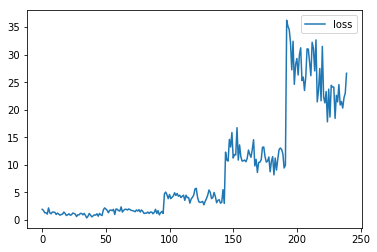

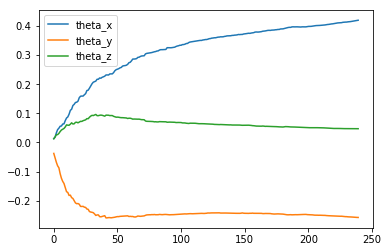

In [13]:
for i_epoch in range(len(n_epochs_list)):
    for i_lr in range(len(lr_list)):
        train_history = pd.read_csv('train_history_{}_{}.csv'.format(i_epoch, i_lr))
        train_history[['loss']].plot();
        train_history[['theta_x', 'theta_y', 'theta_z']].plot();

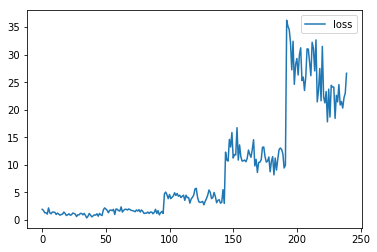

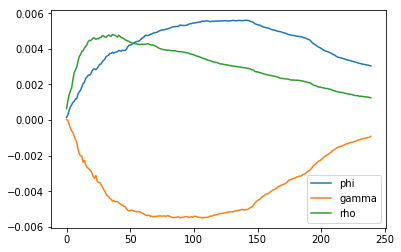

In [14]:
for i_epoch in range(len(n_epochs_list)):
    for i_lr in range(len(lr_list)):
        train_history = pd.read_csv('train_history_{}_{}.csv'.format(i_epoch, i_lr))
        train_history[['loss']].plot();
        train_history[['phi', 'gamma', 'rho']].plot();

In [15]:
dev_history

,,theta_x,theta_y,theta_z,dev_loss,phi,gamma,rho
epoch,lr,,,,,,,
2,0.0003,0.41951972,-0.25728774,0.047286995,19.2422,-0.000913,0.001247,0.003041


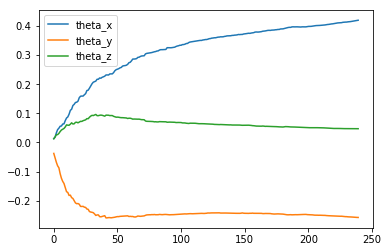

In [16]:
for i_epoch in range(len(n_epochs_list)):
    for i_lr in range(len(lr_list)):
        train_history = pd.read_csv('train_history_{}_{}.csv'.format(i_epoch, i_lr))
        ax = train_history[['theta_x', 'theta_y', 'theta_z']].plot()
        fig = ax.get_figure()
        fig.savefig('./position.png')

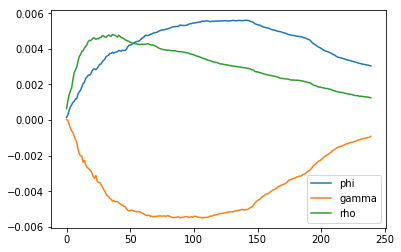

In [17]:
for i_epoch in range(len(n_epochs_list)):
    for i_lr in range(len(lr_list)):
        train_history = pd.read_csv('train_history_{}_{}.csv'.format(i_epoch, i_lr))
        ax = train_history[['phi', 'gamma', 'rho']].plot()
        fig = ax.get_figure()
        fig.savefig('./orientation.png')